In [27]:
import pandas as pd
import numpy as np
import statsmodels
import datetime

# BTC

In [ ]:
btc = pd.read_excel("../data/pricing_data.xlsx", sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

In [ ]:
btc

,Date,Open,High,Low,Close,SMAVG (5) on Close,SMAVG (10) on Close,SMAVG (15) on Close
0,2024-01-01 00:00:00,42443.31,42566.05,42425.25,42548.94,42490.52,42488.01,42546.10
1,2024-01-01 00:30:00,42548.94,42685.12,42545.75,42585.50,42509.30,42495.71,42537.38
2,2024-01-01 01:00:00,42586.10,42634.27,42500.12,42500.12,42506.00,42488.57,42522.40
3,2024-01-01 01:30:00,42500.12,42634.15,42467.88,42600.07,42535.59,42505.98,42520.48
4,2024-01-01 02:00:00,42600.07,42615.70,42522.77,42615.00,42569.93,42520.62,42518.01
...,...,...,...,...,...,...,...,...
20950,2025-03-12 14:30:00,81681.22,81754.86,81277.27,81422.27,81721.64,82004.06,82327.43
20951,2025-03-12 15:00:00,81422.27,81827.30,81303.48,81672.17,81703.27,81901.67,82244.63
20952,2025-03-12 15:30:00,81672.17,82488.72,81564.83,82400.11,81827.39,81899.74,82214.75
20953,2025-03-12 16:00:00,82400.11,82791.12,82019.25,82485.61,81931.74,81913.70,82197.19


# SPY

In [ ]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

# TLT

In [ ]:
tlt = pd.read_excel("../data/pricing_data.xlsx", sheet_name='TLT - iShares 20+ Year Bond')

# Convert the 'Date' column to datetime format
tlt['Date'] = pd.to_datetime(tlt['Date'])

# Sort by date
tlt = tlt.sort_values(by='Date')

# Reset index if needed
tlt.reset_index(drop=True, inplace=True)

In [10]:
def calculate_rsi(df):
    df['PriceChange'] = df['Close'].diff()

    df['Gain'] = df['PriceChange'].where(df['PriceChange'] > 0, 0)
    df['Loss'] = df['PriceChange'].where(df['PriceChange'] < 0, 0)

    window = 10
    df['AvgGain'] = df['Gain'].rolling(window=window, min_periods=1).mean()
    df['AvgLoss'] = df['Loss'].rolling(window=window, min_periods=1).mean()

    df['RS'] = df['AvgGain']/df['AvgLoss']

    df['RSI'] = 100 -(100 / (1+df['RS']))

    df.loc[df.index[:12], 'RSI'] = np.nan

    return df

In [11]:
def calculate_macd(df):
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewn(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df['MACD'].ewn(span=9, adjust=False).mean()
    df['MACD_histogram'] = df['MACD'] - df['MACD_signal']

# Bollinger Bands

In [16]:
def calculate_bollinger_bands(df, window=20, num_std=2):
    """Calculate Bollinger Bands for the given data"""
    # Calculate middle band (SMA20)
    df['BB_middle'] = df['Close'].rolling(window=window).mean()
    
    # Calculate standard deviation
    rolling_std = df['Close'].rolling(window=window).std()
    
    # Calculate upper and lower bands
    df['BB_upper'] = df['BB_middle'] + (rolling_std * num_std)
    df['BB_lower'] = df['BB_middle'] - (rolling_std * num_std)
    
    # Calculate bandwidth and %B
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    df['BB_pctB'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])
    
    return df

In [13]:
def generate_bollinger_signals(df):    
    # Calculate Bollinger Band signals
    # Oversold: Close price below lower band (potential buy)
    # Overbought: Close price above upper band (potential sell)
    bb_oversold = df['Close'] < df['BB_lower']
    bb_overbought = df['Close'] > df['BB_upper']
    
    # Mean reversion potential when price is near bands
    bb_signal = np.where(bb_oversold, 1, np.where(bb_overbought, -1, 0))
    
    # Bollinger Band squeeze (contraction) indicates potential breakout
    bb_squeeze = df['BB_width'] < df['BB_width'].rolling(window=50).mean() * 0.85
    
    return pd.DataFrame({
        'bb_signal': bb_signal,
        'bb_squeeze': bb_squeeze,
        'price': df['Close'],
        'pctB': df['BB_pctB']
    }, index=df.index)


In [ ]:
signals_df = generate_bollinger_signals(calculate_bollinger_bands(btc, btc["SMAVG (5)  on Close"]))

In [ ]:
signals_df[signals_df['bb_signal'] == -1]

,bb_signal,bb_squeeze,price,pctB
16840,-1,False,106279.41,1.004679
16841,-1,False,106342.36,1.005573
16842,-1,False,106753.88,1.011414
16843,-1,False,106826.97,1.012451
16844,-1,False,107110.23,1.016472
...,...,...,...,...
18717,-1,False,106491.12,1.007684
18718,-1,False,106946.03,1.014141
18719,-1,False,106344.69,1.005606
18720,-1,False,106438.38,1.006936


In [14]:
def generate_enhanced_signals(df):
    """Generate trading signals using SMA crossovers and Bollinger Bands"""
    # Calculate basic SMA signals (as before)
    bullish_sma = (df['SMAVG (5)  on Close'] > df['SMAVG (10)  on Close']) & (df['SMAVG (10)  on Close'] > df['SMAVG (15)  on Close'])
    bearish_sma = (df['SMAVG (5)  on Close'] < df['SMAVG (10)  on Close']) & (df['SMAVG (10)  on Close'] < df['SMAVG (15)  on Close'])
    sma_signal = np.where(bullish_sma, 1, np.where(bearish_sma, -1, 0))
    
    # Calculate Bollinger Band signals
    # Oversold: Close price below lower band (potential buy)
    # Overbought: Close price above upper band (potential sell)
    bb_oversold = df['Close'] < df['BB_lower']
    bb_overbought = df['Close'] > df['BB_upper']
    
    # Mean reversion potential when price is near bands
    bb_signal = np.where(bb_oversold, 1, np.where(bb_overbought, -1, 0))
    
    # Bollinger Band squeeze (contraction) indicates potential breakout
    bb_squeeze = df['BB_width'] < df['BB_width'].rolling(window=50).mean() * 0.85
    
    # Combined signal (weighted approach)
    # SMA trend signals get 60% weight, BB signals get 40% weight
    combined_signal = (sma_signal * 0.6) + (bb_signal * 0.4)
    
    return pd.DataFrame({
        'sma_signal': sma_signal,
        'bb_signal': bb_signal,
        'combined_signal': combined_signal,
        'bb_squeeze': bb_squeeze,
        'price': df['Close'],
        'pctB': df['BB_pctB']
    }, index=df.index)


In [17]:
enhanced_signals_df = generate_enhanced_signals(calculate_bollinger_bands(btc, 20))

In [22]:
enhanced_signals_df[enhanced_signals_df['combined_signal'] > 0.6]

,sma_signal,bb_signal,combined_signal,bb_squeeze,price,pctB
1434,1,1,1.0,True,43173.50,-0.234548
2687,1,1,1.0,True,51518.73,-0.005820
4412,1,1,1.0,False,68913.28,-0.033400
4794,1,1,1.0,False,69951.50,-0.037803
6867,1,1,1.0,False,69404.19,-0.015998
7291,1,1,1.0,True,67714.12,-0.059869
8081,1,1,1.0,True,66383.53,-0.031540
11529,1,1,1.0,False,61415.51,-0.002666
11995,1,1,1.0,False,54800.18,-0.170245
18485,1,1,1.0,False,103565.03,-0.076746


In [63]:
def calculate_bb_enhanced_allocation(btc_signal, spy_signal, tlt_signal, current_units, btc_curr_price, spy_curr_price,
                                     tlt_curr_price, portfolio_value):
    """Calculate asset allocation using both SMA and Bollinger Band signals"""
    new_units = current_units.copy()
    MIN_CASH = 0.02*portfolio_value  # Minimum 1% cash

    btc_buy = btc_signal['combined_signal'].iloc[-1] > 0.5
    spy_buy = spy_signal['combined_signal'].iloc[-1] > 0.5
    tlt_buy = tlt_signal['combined_signal'].iloc[-1] > 0.5

    btc_sell = btc_signal['combined_signal'].iloc[-1] < -0.5
    spy_sell = spy_signal['combined_signal'].iloc[-1] < -0.5
    tlt_sell = tlt_signal['combined_signal'].iloc[-1] < -0.5


    # only one buy signal
    if btc_buy & (not spy_buy) & (not tlt_buy):
        if current_units['cash'] > MIN_CASH:
            amt_to_buy = current_units['cash'] - MIN_CASH
            new_units['BTC'] += amt_to_buy/btc_curr_price
            new_units['cash'] = MIN_CASH
        if spy_sell:
            amt = current_units['SPY']*spy_curr_price
            new_units['BTC'] += amt/btc_curr_price
            new_units['SPY'] = 0
        if tlt_sell:
            amt = current_units['TLT']*tlt_curr_price
            new_units['BTC'] += amt/btc_curr_price
            new_units['TLT'] = 0

    elif spy_buy & (not btc_buy) & (not tlt_buy):
        if current_units['cash'] > MIN_CASH:
            amt_to_buy = current_units['cash'] - MIN_CASH
            new_units['SPY'] += amt_to_buy/spy_curr_price
            new_units['cash'] = MIN_CASH
        if btc_sell:
            amt = current_units['BTC']*btc_curr_price
            new_units['SPY'] += amt/spy_curr_price
            new_units['BTC'] = 0
        if tlt_sell:
            amt = current_units['TLT']*tlt_curr_price
            new_units['SPY'] += amt/spy_curr_price
            new_units['TLT'] = 0

    elif tlt_buy & (not spy_buy) & (not btc_buy):
        if current_units['cash'] > MIN_CASH:
            amt_to_buy = current_units['cash'] - MIN_CASH
            new_units['TLT'] += amt_to_buy/tlt_curr_price
            new_units['cash'] = MIN_CASH
        if spy_sell:
            amt = current_units['SPY']*spy_curr_price
            new_units['TLT'] += amt/tlt_curr_price
            new_units['SPY'] = 0
        if btc_sell:
            amt = current_units['BTC']*btc_curr_price
            new_units['TLT'] += amt/tlt_curr_price
            new_units['BTC'] = 0


     # two buy signals (split evenly between buying both assets)
    elif btc_buy & spy_buy & (not tlt_buy):
        if current_units['cash'] > MIN_CASH:
            amt_to_buy = (current_units['cash'] - MIN_CASH)/2
            new_units['BTC'] += amt_to_buy/btc_curr_price
            new_units['SPY'] += amt_to_buy/spy_curr_price
            new_units['cash'] = MIN_CASH
        if tlt_sell:
            amt = (current_units['TLT']*tlt_curr_price)/2
            new_units['SPY'] += amt/spy_curr_price
            new_units['BTC'] += amt/btc_curr_price
            new_units['TLT'] = 0

    elif btc_buy & tlt_buy & (not spy_buy):
        if current_units['cash'] > MIN_CASH:
            amt_to_buy = (current_units['cash'] - MIN_CASH)/2
            new_units['BTC'] += amt_to_buy/btc_curr_price
            new_units['TLT'] += amt_to_buy/tlt_curr_price
            new_units['cash'] = MIN_CASH
        if spy_sell:
            amt = (current_units['SPY']*spy_curr_price)/2
            new_units['TLT'] += amt/tlt_curr_price
            new_units['BTC'] += amt/btc_curr_price
            new_units['SPY'] = 0

    elif tlt_buy & spy_buy & (not btc_buy):
        if current_units['cash'] > MIN_CASH:
            amt_to_buy = (current_units['cash'] - MIN_CASH)/2
            new_units['TLT'] += amt_to_buy/tlt_curr_price
            new_units['SPY'] += amt_to_buy/spy_curr_price
            new_units['cash'] = MIN_CASH
        if btc_sell:
            amt = (current_units['BTC']*btc_curr_price)/2
            new_units['SPY'] += amt/spy_curr_price
            new_units['TLT'] += amt/tlt_curr_price
            new_units['BTC'] = 0

    
    # three buy signals
    elif btc_buy & spy_buy & tlt_buy:
        if current_units['cash'] > MIN_CASH:
            amt_to_buy = (current_units['cash'] - MIN_CASH)/3
            new_units['BTC'] += amt_to_buy/btc_curr_price
            new_units['TLT'] += amt_to_buy/tlt_curr_price
            new_units['SPY'] += amt_to_buy/spy_curr_price
            new_units['cash'] = MIN_CASH

    # zero buy signals
    elif (not btc_buy) & (not spy_buy) & (not tlt_buy):
        if btc_sell:
            new_units['cash'] += new_units['BTC']*btc_curr_price
            new_units['BTC'] = 0
        if spy_sell:
            new_units['cash'] += new_units['SPY']*spy_curr_price
            new_units['SPY'] = 0
        if tlt_sell:
            new_units['cash'] += new_units['TLT']*tlt_curr_price
            new_units['TLT'] = 0

    return new_units
    


In [138]:
def calculate_bb_enhanced_allocation(btc_signal, spy_signal, tlt_signal, current_units, prices, portfolio_value):
    """Enhanced rebalancing with dynamic allocation using Bollinger Bands."""
    new_units = current_units.copy()
    MIN_CASH = 0.02 * portfolio_value

    # Collect signals and prices dynamically
    assets = ['BTC', 'SPY', 'TLT']
    signals = {
        'BTC': btc_signal['combined_signal'].iloc[-1],
        'SPY': spy_signal['combined_signal'].iloc[-1],
        'TLT': tlt_signal['combined_signal'].iloc[-1],
    }

    # Identify buy and sell signals
    buy_assets = [a for a in assets if signals[a] > 0.5]
    sell_assets = [a for a in assets if signals[a] < -0.5]

    # Sell assets with a sell signal
    for asset in sell_assets:
        new_units['cash'] += new_units[asset] * prices[asset]
        new_units[asset] = 0

    # Calculate available cash after maintaining minimum cash
    available_cash = new_units['cash'] - MIN_CASH

    if available_cash > 0 and buy_assets:
        # Split available cash evenly among assets with a buy signal
        cash_per_asset = available_cash / len(buy_assets)

        for asset in buy_assets:
            new_units[asset] += cash_per_asset / prices[asset]

        new_units['cash'] = MIN_CASH

    return new_units


In [ ]:
#if all buy: don't change anything
# if one sell, rest buy: split evenly
# if all sell: convert to cash

In [ ]:
def enhanced_btc_offhours(btc_signal, current_units, portfolio_value, btc_curr_price):
    """Handle BTC trading during off-hours with Bollinger Band signals"""
    new_units = current_units.copy()
    MIN_CASH = 0.01*portfolio_value
    cash_to_use = max(0, new_units['cash'] - MIN_CASH)

    if btc_signal['combined_signal'].iloc[-1] > 0.7:
        amt_to_buy = cash_to_use
        new_units['BTC'] += amt_to_buy/btc_curr_price
        new_units['cash'] -= amt_to_buy
    elif btc_signal['combined_signal'].iloc[-1] > 0.3:
        amt_to_buy = cash_to_use/2
        new_units['BTC'] += amt_to_buy/btc_curr_price
        new_units['cash'] -= amt_to_buy
    elif btc_signal['combined_signal'].iloc[-1] < -0.7:
        amt_to_sell = new_units['BTC']*btc_curr_price/2
        new_units['BTC'] = new_units['BTC']/2
        new_units['cash'] += amt_to_sell
    elif btc_signal['combined_signal'].iloc[-1] < -0.3:
        amt_to_sell = new_units['BTC']*btc_curr_price/4
        new_units['BTC'] = new_units['BTC']/4*3
        new_units['cash'] += amt_to_sell
    
    return new_units

In [207]:
def backtest_bb_strategy(btc_data, spy_data, tlt_data, start_date, end_date):
    """Backtest the Bollinger Band enhanced strategy"""
    # Process data: add Bollinger Bands
    btc_data = calculate_bollinger_bands(btc_data.copy())
    spy_data = calculate_bollinger_bands(spy_data.copy())
    tlt_data = calculate_bollinger_bands(tlt_data.copy())
    
    # Initialize portfolio
    INITIAL_CAPITAL = 1000000
    portfolio_value = INITIAL_CAPITAL
    commission_rate = 0.001
    
    # Initial allocation: SPY (40%), BTC (30%), TLT (25%), Cash (5%)
    current_allocation = {'SPY': 0.8054, 'BTC': 0.1666, 'TLT': 0.00, 'cash': 0.028}
    current_holdings = {asset: portfolio_value * weight for asset, weight in current_allocation.items()}
    # print(current_holdings)
    # Performance tracking
    portfolio_values = []
    #allocations_history = []
    dates = []
    units = []
    prices = []
    current_units = {'BTC': 0, 'SPY': 0, 'TLT': 0, 'cash': 28000}

    
    # Simulation loop
    current_date = start_date
    while current_date <= end_date:
        is_trading_day = current_date.weekday() < 5
        is_market_hours = is_trading_day and (current_date.time() >= datetime.time(22, 30) or (current_date.time() <= datetime.time(4, 30)))

        # Record current state
        portfolio_value = sum(current_holdings.values())
        portfolio_values.append(portfolio_value)
        #allocations_history.append(current_allocation.copy())
        units.append(current_units.copy())
        dates.append(current_date)\
        
        # Filter data up to current date
        btc_current = btc_data[btc_data['Date'] <= current_date]
        btc_current_price = btc_current['Close'].iloc[-1]
        btc_prev_price = btc_current['Close'].iloc[-2]
        current_units['BTC'] = current_holdings['BTC']/btc_prev_price
        #current_holdings['BTC'] = current_units['BTC']*btc_current_price
        
        if not btc_current.empty:
            if is_market_hours:
                # Regular trading hours: all assets tradable
                spy_current = spy_data[spy_data['Date'] <= current_date]
                spy_current_price = spy_current['Close'].iloc[-1]
                spy_prev_price = spy_current['Close'].iloc[-2]
                current_units['SPY'] = current_holdings['SPY']/spy_prev_price
                #current_holdings['SPY'] = current_units['SPY']*spy_current_price
                tlt_current = tlt_data[tlt_data['Date'] <= current_date]
                tlt_current_price = tlt_current['Close'].iloc[-1]
                tlt_prev_price = tlt_current['Close'].iloc[-2]
                current_units['TLT'] = current_holdings['TLT']/tlt_prev_price
                #current_holdings['TLT'] = current_units['TLT']*tlt_current_price
                current_prices = {'BTC': btc_current_price, 'SPY': spy_current_price, 'TLT': tlt_current_price}
                
                if not spy_current.empty and not tlt_current.empty:
                    # Generate enhanced signals with Bollinger Bands
                    btc_signal = generate_enhanced_signals(btc_current.tail(20))
                    spy_signal = generate_enhanced_signals(spy_current.tail(20))
                    tlt_signal = generate_enhanced_signals(tlt_current.tail(40))
                    
                    # Calculate new allocation
                    new_units = calculate_bb_enhanced_allocation(
                        btc_signal, spy_signal, tlt_signal, current_units, current_prices, portfolio_value
                    )

                    current_holdings['BTC'] = new_units['BTC']*btc_current_price
                    current_holdings['SPY'] = new_units['SPY']*spy_current_price
                    current_holdings['TLT'] = new_units['TLT']*tlt_current_price
                    current_holdings['cash'] = new_units['cash']

                    current_units = new_units
                    prices.append({'BTC': btc_current_price, 'SPY': spy_current_price, 'TLT': tlt_current_price})

            else:
                # Off-hours: Only BTC tradable
                btc_signal = generate_enhanced_signals(btc_current.tail(20))
                
                # Use enhanced off-hours logic
                new_units = enhanced_btc_offhours(btc_signal, current_units, portfolio_value, btc_current_price)
                # Only update BTC and CASH holdings
                current_holdings['BTC'] = new_units['BTC']*btc_current_price
                current_holdings['cash'] = new_units['cash']

                current_units = new_units

                prices.append({'BTC': btc_current_price, 'SPY': 0, 'TLT': 0})

        
        # Apply daily interest to cash holdings
        #TREASURY_YIELD = 0.045  # 4.5% annual
        #daily_yield = (1 + TREASURY_YIELD) ** (1/365) - 1
        #current_holdings['CASH'] *= (1 + daily_yield)
        
        # Move to next period
        current_date += datetime.timedelta(minutes=30)
    
    return pd.DataFrame({
        'Date': dates,
        'PortfolioValue': portfolio_values,
        'CashAlloc': [a['cash'] for a in units],
        'BTCAlloc': [a['BTC'] for a in units],
        'BTCPrice': [a['BTC'] for a in prices],
        'SPYAlloc': [a['SPY'] for a in units],
        'SPYPrice': [a['SPY'] for a in prices],
        'TLTAlloc': [a['TLT'] for a in units],
        'TLTPrice': [a['TLT'] for a in prices],
    })


In [208]:
backtesting_df = backtest_bb_strategy(btc, spy, tlt, datetime.datetime(2025, 1, 1), datetime.datetime(2025, 2, 28))

In [209]:
backtesting_df

,Date,PortfolioValue,CashAlloc,BTCAlloc,BTCPrice,SPYAlloc,SPYPrice,TLTAlloc,TLTPrice
0,2025-01-01 00:00:00,1.000000e+06,28000.000000,0.000000,94819.27,0.000000,586.900,0.000000,87.570
1,2025-01-01 00:30:00,9.966862e+05,20000.000000,1.790666,94687.97,1368.029487,587.060,45.677744,87.575
2,2025-01-01 01:00:00,9.966702e+05,19933.723453,1.790666,94358.80,0.000000,585.860,9217.035635,87.525
3,2025-01-01 01:30:00,9.956199e+05,19933.723453,1.790666,93961.69,0.000000,587.205,9217.035635,87.610
4,2025-01-01 02:00:00,9.956922e+05,827438.215392,1.790666,93836.11,0.000000,584.960,0.000000,87.422
...,...,...,...,...,...,...,...,...,...
2780,2025-02-27 22:00:00,1.136769e+06,11367.981557,0.124203,86264.48,0.000000,0.000,12124.371045,0.000
2781,2025-02-27 22:30:00,1.136797e+06,11367.981557,0.124203,84906.03,0.000000,592.100,12124.371045,91.660
2782,2025-02-27 23:00:00,1.133233e+06,11367.981557,0.124203,85593.73,0.000000,595.410,12124.371045,91.429
2783,2025-02-27 23:30:00,1.130518e+06,11367.981557,0.124203,85443.53,0.000000,593.420,12124.371045,91.440


In [191]:
plot_portfolio = backtesting_df[['Date', 'PortfolioValue']]
plot_portfolio

,Date,PortfolioValue
0,2025-01-01 00:00:00,1.000000e+06
1,2025-01-01 00:30:00,9.958922e+05
2,2025-01-01 01:00:00,9.955818e+05
3,2025-01-01 01:30:00,9.941151e+05
4,2025-01-01 02:00:00,9.934450e+05
...,...,...
2780,2025-02-27 22:00:00,1.133840e+06
2781,2025-02-27 22:30:00,1.133868e+06
2782,2025-02-27 23:00:00,1.130313e+06
2783,2025-02-27 23:30:00,1.127605e+06


In [175]:
def calculate_metrics(values):
    returns = values.pct_change().dropna()
    sharpe = np.sqrt(252) * returns.mean() / returns.std()
    max_drawdown = (values / values.cummax() - 1).min()
    total_return = (values.iloc[-1] / values.iloc[0]) - 1
    return {'Sharpe': sharpe, 'Max Drawdown': max_drawdown, 'Total Return': total_return}

In [194]:
spy_portfolio = spy_benchmark(spy, datetime.datetime(2025, 1, 1), datetime.datetime(2025, 2, 28))
btc_portfolio = spy_benchmark(btc, datetime.datetime(2025, 1, 1), datetime.datetime(2025, 2, 28))

In [210]:
print(calculate_metrics(btc_portfolio['Value']))
print(calculate_metrics(spy_portfolio['Value']))
print(calculate_metrics(backtesting_df['PortfolioValue']))

{'Sharpe': -0.12001133047124399, 'Max Drawdown': -0.23187373630796004, 'Total Return': -0.09888011160600885}
{'Sharpe': 0.16318089050773085, 'Max Drawdown': -0.03911978808724692, 'Total Return': 0.011109217924689663}
{'Sharpe': 0.36207023743914163, 'Max Drawdown': -0.08110498162978685, 'Total Return': 0.13063277849852217}


In [187]:
import matplotlib.pyplot as plt

In [ ]:
# Compare performance
portfolio_metrics_validation = calculate_metrics(backtesting_df['PortfolioValue'])
#cash_metrics_validation = calculate_metrics(cash_values_validation)
spy_metrics_validation = calculate_metrics(spy_portfolio['Value'])

# Plot results
def plot_performance_comparison():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Validation period
    ax1.plot(backtesting_df['PortfolioValue'], label='Portfolio Strategy')
    #ax1.plot(cash_values_validation, label='Cash (Treasury)')
    ax1.plot(spy_portfolio['Value'], label='S&P500 (SPY)')
    ax1.set_title('Validation Period (Jan-Feb 2025)')
    ax1.legend()
    
    # Evaluation period
    ax2.plot(backtesting_df['PortfolioValue'], label='Portfolio Strategy')
    #ax2.plot(cash_values_evaluation, label='Cash (Treasury)')
    ax2.plot(spy_portfolio['Value'], label='S&P500 (SPY)')
    ax2.set_title('Evaluation Period (Mar 2025)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_performance_comparison()

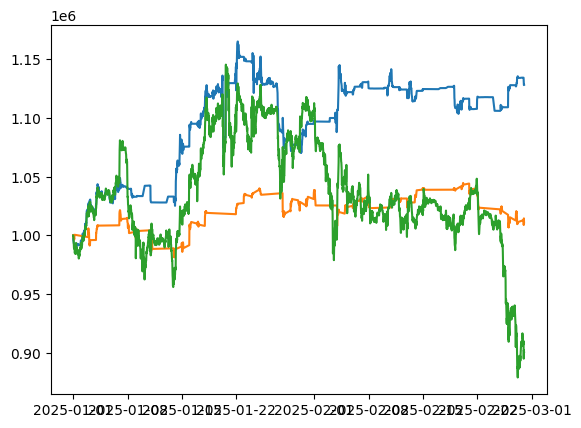

In [196]:
plt.plot(plot_portfolio['Date'], plot_portfolio['PortfolioValue'], label = 'Portfolio Strategy')
plt.plot(spy_portfolio['Date'], spy_portfolio['Value'], label = 'SPY benchmark')
plt.plot(btc_portfolio['Date'], btc_portfolio['Value'], label = 'BTC benchmark')
plt.show()

In [ ]:
def spy_benchmark(spy_data, start_date, end_date):
    """Simulate performance of $1M fully invested in SPY"""
    spy_subset = spy_data[(spy_data['Date'] >= start_date) & (spy_data['Date'] <= end_date)]
    spy_returns = spy_subset['Close'].pct_change().fillna(0)
    
    value = 1000000
    values = [value]
    
    for ret in spy_returns:
        value *= (1 + ret)
        values.append(value)
    
    return pd.DataFrame({
        'Date': spy_subset['Date'],
        'Value': values[:len(spy_subset)]
    })



def tbill_benchmark(start_date, end_date):
    """Simulate performance of $1M in 3-month Treasury Bill"""
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    daily_yield = (1 + TREASURY_YIELD) ** (1/365) - 1
    
    values = [INITIAL_CAPITAL * (1 + daily_yield) ** i for i in range(len(dates))]
    
    return pd.DataFrame({
        'Date': dates,
        'Value': values
    })